# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [6]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [7]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [16]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)
# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5
print("Full model Accuracy:", accuracy_score(yf_test, ypred_full))
print("Reduced model Accuracy:", accuracy_score(yf_test, ypred_reduced))
print("Full model Precision:", precision_score(yf_test, ypred_full))
print("Reduced model Precision:", precision_score(yf_test, ypred_reduced))
print("Full model Recall:", recall_score(yf_test, ypred_full))
print("Reduced model Recall:", recall_score(yf_test, ypred_reduced))

Full model Accuracy: 0.7233333333333334
Reduced model Accuracy: 0.7166666666666667
Full model Precision: 0.7333333333333333
Reduced model Precision: 0.7364341085271318
Full model Recall: 0.678082191780822
Reduced model Recall: 0.6506849315068494


## 4) Plot ROC and Precision–Recall Curves

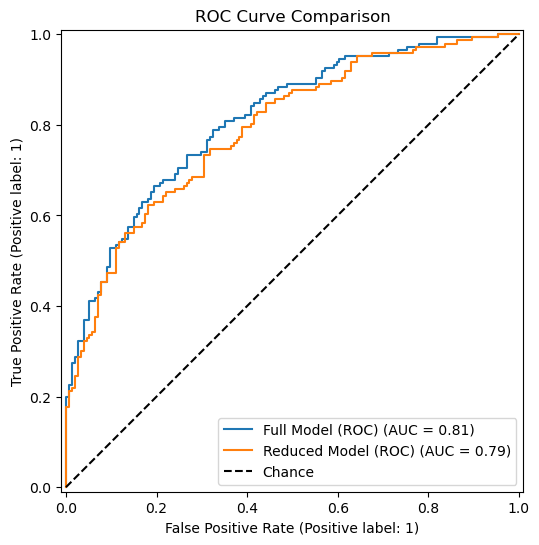

In [13]:
# Create a figure for the ROC curves
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Plot ROC curve for the full model
RocCurveDisplay.from_estimator(
    clf_full,
    Xf_test,
    yf_test,
    name='Full Model (ROC)',
    ax=ax
)

# Plot ROC curve for the reduced model
RocCurveDisplay.from_estimator(
    clf_reduced,
    Xr_test,
    yr_test,
    name='Reduced Model (ROC)',
    ax=ax
)

ax.set_title('ROC Curve Comparison')
ax.plot([0, 1], [0, 1], 'k--', label='Chance') # Add the random guess line
ax.legend(loc='lower right')
plt.show()


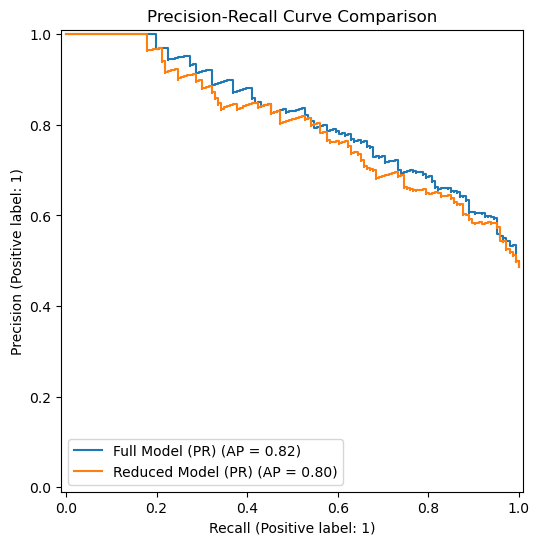

In [14]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

PrecisionRecallDisplay.from_estimator(
    clf_full,
    Xf_test,
    yf_test,
    name='Full Model (PR)',
    ax=ax
)

PrecisionRecallDisplay.from_estimator(
    clf_reduced,
    Xr_test,
    yr_test,
    name='Reduced Model (PR)',
    ax=ax
)

ax.set_title('Precision-Recall Curve Comparison')
ax.legend(loc='lower left')
plt.show()

## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

### Answer

The model with PWAT is better than the model with just CAPE as a predictor by a using the greater area under the curve for the ROC and PR.  This means that there is additional information when PWAT and Shear are added to the model, albeit marginal.

The full model has a better recall, which maximizes the event detection.

However, the reduced model has a better precision as shown above, which would minimize false alarms.